<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Аналитика" data-toc-modified-id="Аналитика-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Аналитика</a></span><ul class="toc-item"><li><span><a href="#Импорт-и-проверка-на-корректность" data-toc-modified-id="Импорт-и-проверка-на-корректность-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт и проверка на корректность</a></span></li><li><span><a href="#Топ-10-городов-по-количеству-рейсов" data-toc-modified-id="Топ-10-городов-по-количеству-рейсов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Топ-10 городов по количеству рейсов</a></span></li><li><span><a href="#Графики" data-toc-modified-id="Графики-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Графики</a></span><ul class="toc-item"><li><span><a href="#Модели-самолётов-и-количество-рейсов" data-toc-modified-id="Модели-самолётов-и-количество-рейсов-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Модели самолётов и количество рейсов</a></span></li><li><span><a href="#Города-и-количество-рейсов" data-toc-modified-id="Города-и-количество-рейсов-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Города и количество рейсов</a></span></li><li><span><a href="#Топ-10-городов-и-количество-рейсов" data-toc-modified-id="Топ-10-городов-и-количество-рейсов-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Топ-10 городов и количество рейсов</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Запросы к БД

### Количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года

``` mysql
SELECT 
aircrafts.model as model,
count(flights.flight_id) AS flights_amount
FROM 
flights join aircrafts on aircrafts.aircraft_code = flights.aircraft_code
where 
flights.departure_time::date BETWEEN '2018-09-1' and '2018-09-30'
group by 
aircrafts.model;
```

### Количество прибывающих рейсов в день для каждого города за август 2018 года

``` mysql
select
    SUBQ.city,
    avg(SUBQ.cnt) as average_flights
from(
    select
        airports.city as city,
        extract(day from flights.arrival_time::date) AS trunc_date,
        count(flights.flight_id) as cnt
    from
        flights
        inner join airports on flights.arrival_airport = airports.airport_code
    where
        flights.arrival_time::date between '2018-08-1' and '2018-08-31'
    group by
        airports.city,
        trunc_date) as SUBQ
group by
        SUBQ.city
```

# Спрос на рейсы авиакомпании

Вы аналитик российской авиакомпании F9, выполняющей внутренние пассажирские перевозки. Важно понять предпочтения пользователей, покупающих билеты на разные направления.

Вам предстоит изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие культурные фестивали.

У вас есть файлы с результатами запросов из предыдущих заданий.

**query_1.csv** — результат первого запроса. В нём содержится такая информация:

- *model* — **модель самолета;
- *flights_amount* — количество рейсов для каждой модели самолетов *model* в сентябре 2018 года.

**query_3.csv** — результат третьего запроса. В нём содержится такая информация:

- *city* — город;
- *average_flights* — среднее количество рейсов, прибывающих в город (*city*) за день в сентябре 2018 года.

 Для этих двух наборов данных нужно:

- импортировать файлы;
- изучить данные в них;
- проверить типы данных на корректность;
- выбрать топ-10 городов по количеству рейсов;
- построить графики: модели самолётов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов;
- сделать выводы по каждому из графиков, пояснить результат.


## Аналитика

### Импорт и проверка на корректность

In [1]:
!pip install --user folium

In [2]:
!pip install --user geopy

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns
from geopy.geocoders import Nominatim
from collections import Counter

In [4]:
try:
    query_1=pd.read_csv('query_1.csv')
except:
    query_1 = pd.read_csv('/datasets/query_1.csv')
query_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [5]:
query_1.sample(5)

,model,flights_amount
6,Cessna 208 Caravan,4557
1,Airbus A321-200,960
4,Boeing 777-300,300
2,Boeing 737-300,630
0,Airbus A319-100,607


In [6]:
query_1.describe()

,flights_amount
count,8.000000
mean,2035.625000
std,1965.203947
min,300.000000
25%,605.250000
50%,795.000000
75%,4250.250000
max,4557.000000


In [7]:
try:
    query_3=pd.read_csv('query_3.csv')
except:
    query_3 = pd.read_csv('/datasets/query_3.csv')
query_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [8]:
query_3.sample(5)

,city,average_flights
38,Магадан,1.357143
3,Архангельск,5.354839
91,Хабаровск,6.548387
74,Сочи,9.612903
75,Ставрополь,2.000000


In [9]:
query_3.describe()

,average_flights
count,101.000000
mean,5.494189
std,13.119790
min,1.000000
25%,2.000000
50%,3.000000
75%,5.870968
max,129.774194


In [10]:
len(query_3['city'].unique())

101

In [11]:
len(Counter(query_3['city']))

101

Данные загрузили, пропусков нет, дубликатов нет, все типы приведены к нужным.

### Топ-10 городов по количеству рейсов

In [12]:
top10=query_3.sort_values('average_flights', ascending=False).head(10)
top10

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


### Графики

#### Модели самолётов и количество рейсов

In [13]:
top_air=query_1.sort_values('flights_amount')
top_air

,model,flights_amount
4,Boeing 777-300,300
3,Boeing 767-300,600
0,Airbus A319-100,607
2,Boeing 737-300,630
1,Airbus A321-200,960
7,Sukhoi SuperJet-100,4185
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557


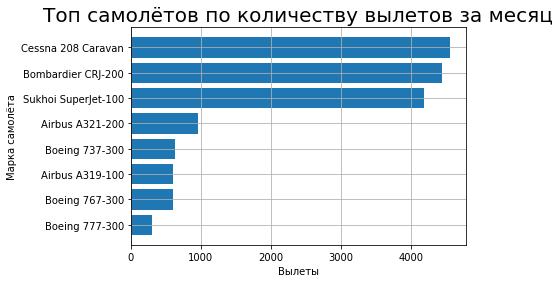

In [14]:
plt.barh(top_air['model'],top_air['flights_amount'])
plt.grid()
plt.xlabel('Вылеты')
plt.ylabel('Марка самолёта')
plt.title('Топ самолётов по количеству вылетов за месяц',fontsize=20)
plt.show()

По графику явно выделяется тройка лидеров с количеством вылетов за 4000 в месяц, отсавшиеся 4 модели образовали группу с количетсвом вылетов до 1000.

#### Города и количество рейсов

In [15]:
query_3=query_3.sort_values('average_flights')
query_3

,city,average_flights
8,Благовещенск,1.000000
1,Анадырь,1.000000
31,Комсомольск-на-Амуре,1.000000
76,Стрежевой,1.000000
49,Нефтеюганск,1.000000
...,...,...
20,Екатеринбург,11.322581
33,Красноярск,11.580645
54,Новосибирск,17.322581
70,Санкт-Петербург,31.161290


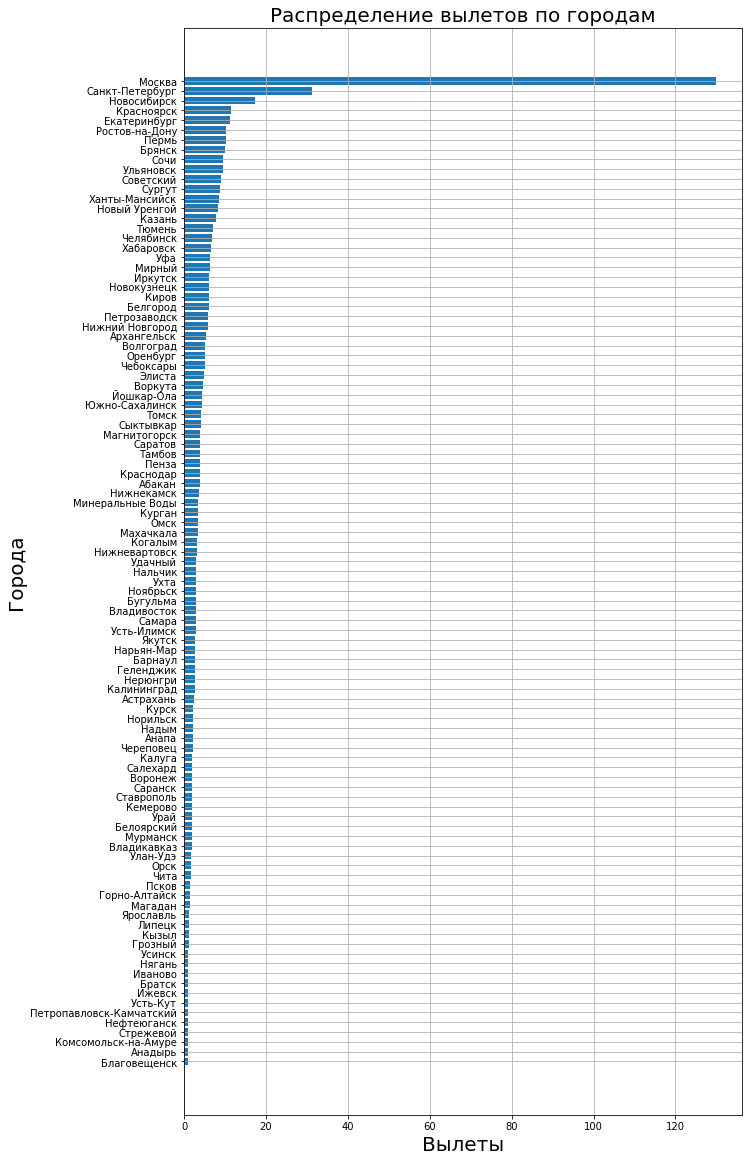

In [16]:
plt.figure(figsize=(10,20))
plt.barh(query_3['city'],query_3['average_flights'])
plt.grid()
plt.xlabel('Вылеты',fontsize=20)
plt.ylabel('Города',fontsize=20)
plt.title('Распределение вылетов по городам',fontsize=20)
plt.show()

Столица с показателем за 120 в 4 раза превосходит ближайшего преследователя с результатом около 30.
Остальные города принимают не более 20 рейсов в день.

In [17]:
m = folium.Map(location=[63.802920, 96.456011],zoom_start=3) 
m

In [18]:
geolocator = Nominatim(user_agent='myapplication')

In [19]:
def lat(city):
    location = geolocator.geocode(city)
    lat=float(location.raw['lat'])
    return lat

In [20]:
def lon(city):
    location = geolocator.geocode(city)
    lon=float(location.raw['lon'])
    return lon

In [21]:
query_3['lat']=query_3['city'].apply(lat)
query_3

,city,average_flights,lat
8,Благовещенск,1.000000,50.290527
1,Анадырь,1.000000,64.731688
31,Комсомольск-на-Амуре,1.000000,50.550877
76,Стрежевой,1.000000,60.732758
49,Нефтеюганск,1.000000,61.090309
...,...,...,...
20,Екатеринбург,11.322581,56.839104
33,Красноярск,11.580645,56.009097
54,Новосибирск,17.322581,54.967814
70,Санкт-Петербург,31.161290,59.938732


In [22]:
query_3['lon']=query_3['city'].apply(lon)
query_3

,city,average_flights,lat,lon
8,Благовещенск,1.000000,50.290527,127.527161
1,Анадырь,1.000000,64.731688,177.506092
31,Комсомольск-на-Амуре,1.000000,50.550877,137.020782
76,Стрежевой,1.000000,60.732758,77.600807
49,Нефтеюганск,1.000000,61.090309,72.610100
...,...,...,...,...
20,Екатеринбург,11.322581,56.839104,60.608250
33,Красноярск,11.580645,56.009097,92.872515
54,Новосибирск,17.322581,54.967814,82.951599
70,Санкт-Петербург,31.161290,59.938732,30.316229


In [23]:
HeatMap(data=query_3[['lat', 'lon', 'average_flights']]).add_to(m)
m

Здесь я попытался сделать тепловую карту.

#### Топ-10 городов и количество рейсов

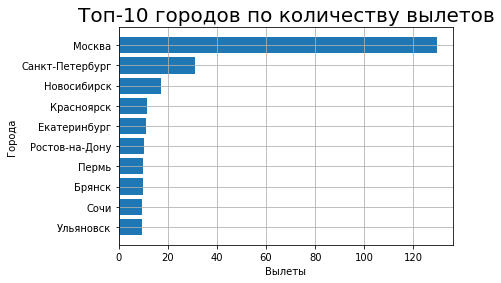

In [24]:
plt.barh(top10['city'][::-1],top10['average_flights'][::-1])
plt.grid()
plt.xlabel('Вылеты')
plt.ylabel('Города')
plt.title('Топ-10 городов по количеству вылетов',fontsize=20)
plt.show()

В топе находятся города миллионики и количество полетов напрямую зависит от численности населения. Новосибирск выделяется среди оставшихся, потому что является аэропортом международного уровня и выполяет фунцию некой развязки во всей восточной части России.

### Вывод

На основании полученных данных мы смогли построить наглядные графики и сделать интересные выводы:

 - Москва явно выделяется среди всех городов страны
 - В топ-3 также вошли Санкт-Петербург (вторая столица) и Новосибирск (ключевая развязка восточной России)
 - На удивлении больше всего вылетов совершают маломерные самолёты (малый спрос, недостаточное количество крупных аэропортов, малые расстояния)
 
 На основании полученных данных можно скоректировать дальнейшую работу по закупкам и техобслуживанию самолетов и аэропортов, а также развитию авиаперевозок в регионах.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Файлы изучены
- [x]  Типы данных проверены на корректность
- [x]  Выбран топ-10 городов по количеству рейсов
- [x]  Построен график «Модели самолётов и количество рейсов»
- [x]  Построен график «Города и количество рейсов»
- [x]  Построен график «Топ-10 городов и количество рейсов»
- [x]  На каждом этапе написаны выводы
- [x]  Написан общий вывод